In [1]:
import os, shutil
import subprocess as subp
import numpy as np
import mdtraj
import matplotlib.pyplot as plt
import scipy.signal
import multiprocessing

In [2]:
# Function that load the real data
def load_real_data(epoch, f=None):
    fval = []
    for i in range(1,N+1):
        d = "epoch%02d/rep%02d/"%(epoch, i)
        fval.append(np.load(d+"fval.npy"))
        print("Loaded fval from %sfval.npy"%d)
    
    reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
    frms = [np.arange(len(f)) for f in fval]
    
    return np.concatenate(reps), (np.concatenate(fval)-0.799)*100/(1.4-0.799), np.concatenate(frms)


def rand_func(f,n=600,i=1):
    x = np.linspace(-10,100, 10000)
    pdf = f(x,i)
    pdf /= np.sum(pdf)
    cdf = np.cumsum(pdf)
    u = np.random.random(n)
    return np.array([x[np.argmax(uu<=cdf)] for uu in u])
    

# Function for "loading" random data
def load_data(epoch, f=np.sin):
    fval = []
    for i in range(1,N+1):
        d = "epoch%02d/rep%02d/"%(epoch, i)
        fval.append(rand_func(f,i=epoch))
        print("Faked fval for %sfval.npy"%d)
    
    reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
    frms = [np.arange(len(f)) for f in fval]
    
    return np.concatenate(reps), np.concatenate(fval), np.concatenate(frms)


In [3]:
# Choose which data to load
#load_data = load_real_data
# Arbitrary propability distribution
def func(x,i):
    return np.exp(-0.5*((x-15*(i-1))/(10/i))**2)

def func2(x,i):
    return np.exp(-0.5*((x-10*(i**2-1))/(10))**2)

def U(x):
    """ The potential, in kbT
    """
    return np.sin(x/10)

epochs = 3
N=16
maxval=100
minval=0
fval = []
reps = []
frms = []
for i in range(1,epochs+1):
    r,f,fr = load_data(i,func2)
    reps.append(r)
    fval.append(f)
    frms.append(fr)

    
epcs = [np.full(f.shape,i+1) for i,f in enumerate(fval)]

reps = np.concatenate(reps)
fval = np.concatenate(fval)
epcs = np.concatenate(epcs)
frms = np.concatenate(frms)

Faked fval for epoch01/rep01/fval.npy
Faked fval for epoch01/rep02/fval.npy
Faked fval for epoch01/rep03/fval.npy
Faked fval for epoch01/rep04/fval.npy
Faked fval for epoch01/rep05/fval.npy
Faked fval for epoch01/rep06/fval.npy
Faked fval for epoch01/rep07/fval.npy
Faked fval for epoch01/rep08/fval.npy
Faked fval for epoch01/rep09/fval.npy
Faked fval for epoch01/rep10/fval.npy
Faked fval for epoch01/rep11/fval.npy
Faked fval for epoch01/rep12/fval.npy
Faked fval for epoch01/rep13/fval.npy
Faked fval for epoch01/rep14/fval.npy
Faked fval for epoch01/rep15/fval.npy
Faked fval for epoch01/rep16/fval.npy
Faked fval for epoch02/rep01/fval.npy
Faked fval for epoch02/rep02/fval.npy
Faked fval for epoch02/rep03/fval.npy
Faked fval for epoch02/rep04/fval.npy
Faked fval for epoch02/rep05/fval.npy
Faked fval for epoch02/rep06/fval.npy
Faked fval for epoch02/rep07/fval.npy
Faked fval for epoch02/rep08/fval.npy
Faked fval for epoch02/rep09/fval.npy
Faked fval for epoch02/rep10/fval.npy
Faked fval f

28800
100.0 0 24933 124 1.0


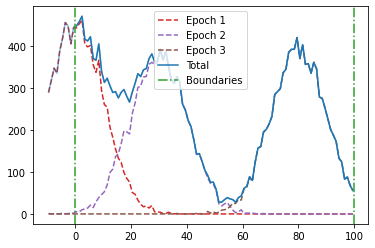

In [4]:
_largest_val,_lowest_val=0,0
def make_hist(fval):
    global _largest_val,_lowest_val
    print(len(fval))
    _largest_val = np.max(fval)
    _lowest_val  = np.min(fval)
    _binmax = min(_largest_val, maxval)
    _binmin = max(_lowest_val,  minval)
    _maxbins = np.sum((fval>minval)*(fval<maxval))//200
    _binsize = (_binmax-_binmin)/min(_maxbins,100)
    print(_binmax,_binmin, np.sum((fval>minval)*(fval<maxval)),_maxbins,_binsize)
    bin_edges = np.arange(_lowest_val,_largest_val+_binsize , _binsize)
    hist, bin_edges = np.histogram(fval, bins=bin_edges)
    bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
    # higher edge larger than minval AND lower edge lower than maxval
    mask = (bin_edges[1:]>minval)*(bin_edges[:-1]<maxval)

    for i in range(1,epochs+1):
        _ep_hist, _ = np.histogram(fval[epcs==i], bins=bin_edges)
        plt.plot(bin_centers, _ep_hist, "--", color="C%d"%(i+2), label="Epoch %d"%i)


    plt.plot(bin_centers, hist, color="C0", alpha=0.5)
    plt.plot(bin_centers[mask], hist[mask], color="C0", label="Total")
    plt.axvline(minval, linestyle="-.", color="C2", label="Boundaries")
    plt.axvline(maxval, linestyle="-.", color="C2")
    plt.legend()
    plt.show()
    return hist, bin_edges, bin_centers, mask

hist, bin_edges, bin_centers, mask = make_hist(fval)

[16 55] {'prominences': array([ 82.11111111, 346.66666667]), 'left_bases': array([0, 0]), 'right_bases': array([29, 79]), 'widths': array([12.31003792, 27.13615764]), 'width_heights': array([-328.94444444, -207.66666667]), 'left_ips': array([10.52659574, 40.88669951]), 'right_ips': array([22.83663366, 68.02285714])}
[29 79] {'prominences': array([ 82.11111111, 257.11111111]), 'left_bases': array([16, 55]), 'right_bases': array([55, 95]), 'widths': array([11.69418825, 18.87022973]), 'width_heights': array([328.94444444, 252.44444444]), 'left_ips': array([22.83663366, 70.2826087 ]), 'right_ips': array([34.53082192, 89.15283843])}
[65, 109] [7.34313725 6.65686275]
[65, 109] [7.34313725 6.65686275]
16 (array([ 65, 109]), array([9, 7]))


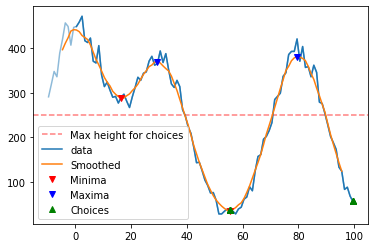

[65, 109, 65, 65, 65, 65, 65, 65, 65, 109, 109, 109, 109, 109, 109, 65]

In [5]:
from math import floor, ceil

def rolling_mean(data, window=10, center = True, fill=np.nan):
    if(center):
        start_offset = floor(window/2)
        end_offset   = -ceil(window/2)+1
        if(end_offset==0): end_offset=None
    else:
        start_offset = window-1
        end_offset   = None

    window-=1
    if(window==0): window=None

    cumsum = np.nancumsum(data, axis=0, dtype=float)
    mean   = np.full_like(cumsum, fill)
    mean[start_offset:end_offset] = (cumsum[window:]-cumsum[:-window])/window

    return mean

def choose_bins(hist,mask,bin_centers):
    _smoothed = rolling_mean(-hist)
    _nanmask = np.isfinite(_smoothed)*mask
    _peaks,_que = scipy.signal.find_peaks(_smoothed[_nanmask], width=5, distance=10)
    _peaks2,_que2 = scipy.signal.find_peaks(-_smoothed[_nanmask], width=5, distance=10)
    print(_peaks, _que)
    print(_peaks2, _que2)


    _maxh = np.max(hist[mask])
    _minh = np.min(hist[mask])
    # If not ends have sampled been, make sure min height set to zero is
    if(_largest_val<maxval or _lowest_val>minval):
        _minh=0

    _crith = (_maxh-_minh)/2+_minh

    choices = []
    # convert from masked indices to unmasked
    _indexes = np.arange(len(hist))[_nanmask]
    for p in _peaks:
        if(hist[_nanmask][p]<_crith):
            choices.append(_indexes[p])

    _zero_mask = mask*(hist!=0)
    _indexes = np.arange(len(hist))[_zero_mask]

    # TODO: refactor below
    #Handle not peaks-edge case
    if(len(choices)==0):
        if(hist[mask][-1]<_crith):
            choices.append(_indexes[-1])
        if(hist[mask][0]<_crith):
            choices.append(_indexes[0])
    else:
        # Check if first/last extrema is a maxima -> also include the far end(s)
        if(_peaks2.size>0 and _peaks[-1]<_peaks2[-1] and hist[mask][-1]<_crith):
            choices.append(_indexes[-1])
        if(_peaks2.size>0 and _peaks[0]>_peaks2[0] and hist[mask][0]<_crith):
            choices.append(_indexes[0])

    _weights = [(_crith-hist[c]) for c in choices]
    _weights /= np.sum(_weights)
    print(choices,(_weights*(N-len(choices))))
    _srt_ind = np.argsort(-_weights)
    print([choices[i] for i in _srt_ind],(_weights[_srt_ind]*(N-len(choices))))

    # Each point has been added once
    _len_choice = len(choices)
    # Add more depending on weight. Multiplication is floored, so between 0 and _len_choice-1 too few are added
    for i in _srt_ind:
        for j in range(floor(_weights[i]*(N-_len_choice))):
            choices.append(choices[i])

    # Fill the rest in sorted order
    for i in range(N-len(choices)):
        choices.append(choices[_srt_ind[i]])


    print(len(choices), np.unique(choices, return_counts=True))

    plt.axhline(_crith, linestyle="--", c="r", alpha=0.5, label="Max height for choices")
    plt.plot(bin_centers, hist, color="C0", alpha=0.5)
    plt.plot(bin_centers[mask], hist[mask], color="C0", label="data")
    plt.plot(bin_centers, -_smoothed, color="C1", label="Smoothed")
    plt.plot(bin_centers[_nanmask][_peaks], -_smoothed[_nanmask][_peaks], "rv", label="Minima")
    plt.plot(bin_centers[_nanmask][_peaks2], -_smoothed[_nanmask][_peaks2], "bv", label="Maxima")
    plt.plot(bin_centers[choices], hist[choices], "g^", label="Choices")
    plt.legend()
    plt.show()
    return choices

choose_bins(hist,mask,bin_centers)

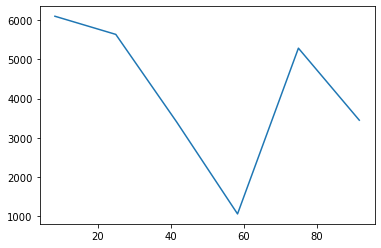

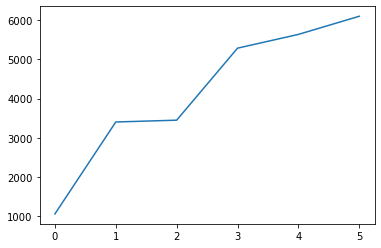

28 51.5 51.0 52.0
75 48.5 48.0 49.0
56 99.5 99.0 100.0


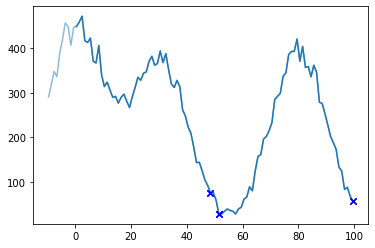

In [6]:
_big_bins = np.linspace(bin_edges[:-1][mask][0], bin_edges[1:][mask][-1], 7)

_big_hist, _ = np.histogram(fval, bins=_big_bins)
_big_bin_cnt = (_big_bins[1:]+_big_bins[:-1])/2

_srt_ndx = np.argsort(_big_hist)

plt.plot(_big_bin_cnt,_big_hist)
plt.show()

plt.plot(_big_hist[_srt_ndx])
plt.show()


_choices = []
_choose_bins=3
for i in range(_choose_bins):
    _binmask = mask*(bin_centers>_big_bins[_srt_ndx[i]])*(bin_centers<_big_bins[_srt_ndx[i]+1])*(hist!=0)
    _smallest_bin = np.argmin(hist[_binmask])
    _choices.append(np.arange(len(hist))[_binmask][_smallest_bin])
    print(hist[_choices[-1]], bin_centers[_choices[-1]], bin_edges[_choices[-1]], bin_edges[_choices[-1]+1])

for i in range(N-len(_choices)):
    _choices.append(_choices[i])

chosen_bins=_choices

plt.plot(bin_centers, hist, color="C0", alpha=0.5)
plt.plot(bin_centers[mask], hist[mask], color="C0")
plt.plot(bin_centers[_choices], hist[_choices], "bx")
plt.show()

[20.0330033  20.99009901 63.05830583 ...  2.81628163 30.4070407
 76.35863586] [ 8.53685369 65.20352035 52.55225523 ... 29.8569857  83.79537954
 77.45874587]
(14400,) (14400,)


/home/paajasan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/paajasan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/paajasan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/paajasan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/paajasan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/paajasan/anaconda3/lib/python3.7/site-p

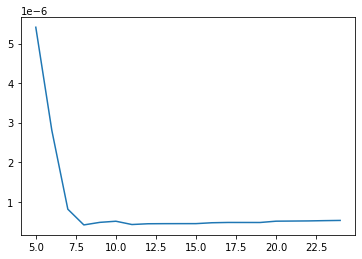

[  2.18123788  15.57236048  29.03424797  55.2265262   80.10114429
  98.92968305 121.34469335] [-4.52699665e-04  1.07448157e-04 -8.24193571e-05  1.04620511e-04
 -1.31035306e-04  2.74677335e-04 -1.87888279e-03]
[15.57236048 55.2265262  98.92968305] [0.00010745 0.00010462 0.00027468]
8


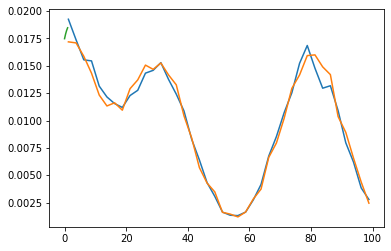

In [7]:
from sklearn.model_selection import train_test_split
_f_train, _f_test = train_test_split(fval, test_size=0.5)
print(_f_test, _f_train)
print(_f_test.shape, _f_train.shape)

_ttbins = np.linspace(bin_edges[:-1][mask][0],bin_edges[1:][mask][-1], 41)
_bincents = (_ttbins[:-1]+_ttbins[1:])/2

_train_hist, _ = np.histogram(_f_train, bins=_ttbins, density=True)
_test_hist,  _ = np.histogram(_f_test,  bins=_ttbins, density=True)

_degs = np.arange(5,25)
_pols = []
_chi2 = []

_x = np.linspace(bin_edges[:-1][mask][0],bin_edges[1:][mask][0],10000)

for d in _degs:
    _pol = np.poly1d(np.polyfit(_bincents, _train_hist, d))
    _pols.append(_pol)
    _dist = np.sum((_test_hist-_pol(_bincents))**2)/len(_bincents)
    _chi2.append(_dist)
    #plt.plot(_x, _pol(_x))

plt.plot(_degs, _chi2)
plt.show()


_pol_arg = np.argmin(_chi2)
dpol = _pols[_pol_arg].deriv()
ddpol = dpol.deriv()

# Find real unique roots
extr = dpol.roots
extr = np.unique(np.real(extr[np.isreal(extr)]))
print(extr, ddpol(extr))

# filter values outside our range
extr = extr[(_ttbins[0]<extr)*(extr<_ttbins[-1])]
# filter maxima and plateaus
extr = extr[ddpol(extr)>0]
print(extr, ddpol(extr))




print(_degs[_pol_arg])
    
plt.plot(_bincents, _train_hist)
plt.plot(_bincents, _test_hist)
plt.plot(_x, _pols[_pol_arg](_x))
plt.show()

[-35.77621655   1.88675359  15.55449049  29.35738914  55.24926118
  80.31061662  99.58788707] [506.10343362  -9.23588772   2.60545454  -2.1462784    2.71868645
  -3.1509178    7.64540084]
[15.55449049 55.24926118] [2.60545454 2.71868645]
16


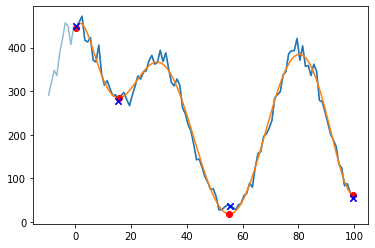

In [8]:
p = np.polyfit(bin_centers[mask], hist[mask], 10)
pol = np.poly1d(p)
dpol = pol.deriv()
ddpol = dpol.deriv()

_minbin = bin_centers[mask][0]
_maxbin = bin_centers[mask][-1]

# Find real unique roots
extr = dpol.roots
extr = np.unique(np.real(extr[np.isreal(extr)]))
print(extr, ddpol(extr))

# filter values outside our range
extr = extr[(_minbin<extr)*(extr<_maxbin)]
# filter maxima and plateaus
extr = extr[ddpol(extr)>0]
print(extr, ddpol(extr))

# ends
extr = list(extr)
if(dpol(_minbin)>0):
    extr.append(_minbin)
if(dpol(_maxbin)<0):
    extr.append(_maxbin)
    
extr = np.array(extr)


_choices = []
for e in extr:
    _choices.append(np.argmin(np.abs(bin_centers-e+np.where(hist==0, np.inf, 0))))

for i in range(N-len(_choices)):
    _choices.append(_choices[i])

print(len(_choices))
_choices=np.array(_choices)

_x = np.linspace(_minbin,_maxbin,10000)

plt.plot(bin_centers, hist, color="C0", alpha=0.5)
plt.plot(bin_centers[mask], hist[mask], color="C0")
plt.plot(_x, pol(_x), color="C1")
plt.plot(extr, pol(extr), "ro")
plt.plot(bin_centers[_choices], hist[_choices], "bx")
plt.show()

In [9]:
def U(x):
    """ The potential, in kbT
    """
    return -np.sin(x/10)/5

def random_walk(start, nsteps=700, substeps=30, stepsize=0.1):
    pos = np.zeros(nsteps)
    x = start
    rng = np.random.default_rng()
    for i in range(nsteps):
        for j in range(substeps):
            x_trials = np.linspace(-10*stepsize, 10*stepsize,1000)
            p  = np.exp(-U(x+x_trials))*np.exp(-0.5*(x_trials/(stepsize))**2)
            ptot = np.sum(p)
            p /= ptot
            x += rng.choice(x_trials, p=p)
        
        pos[i]=x
        
    return pos

def choose_frames(chosen_bins):
    global bin_edges, fval, epcs, reps, frms
    _rng = np.random.default_rng()
    # lists for value, rpoch, rep and frame
    v,e,r,f=[],[],[],[]
    for bi in chosen_bins:
        vals_in_bin = (fval >= bin_edges[bi])*(fval < bin_edges[bi+1])
        ndx = _rng.choice(np.sum(vals_in_bin))
        
        v.append(fval[vals_in_bin][ndx])
        e.append(epcs[vals_in_bin][ndx])
        r.append(reps[vals_in_bin][ndx])
        f.append(frms[vals_in_bin][ndx])
    
    return np.array(v), np.array(e), np.array(r), np.array(f)

def simulate_epoch(epoch, chosen_bins):
    v,e,r,f = choose_frames(chosen_bins)

    with multiprocessing.Pool(min(multiprocessing.cpu_count(),N)) as p:
        fval = p.map(random_walk, v)
        
    reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
    frms = [np.arange(len(f)) for f in fval]
    
    return np.concatenate(reps), np.concatenate(fval), np.concatenate(frms)

def simulate_data(epoch, f=None):
    if(epoch==1):
        v = [0]*N
        
        with multiprocessing.Pool(min(multiprocessing.cpu_count(),N)) as p:
            fval = p.map(random_walk, v)
            
        reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
        frms = [np.arange(len(f)) for f in fval]

        return np.concatenate(reps), np.concatenate(fval), np.concatenate(frms)
    else:
        return simulate_epoch(epoch,chosen_bins)
        
    

11200
26.600600600600117 0 6661 33 0.8060788060787915


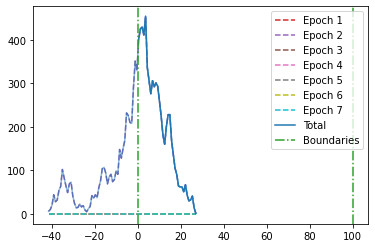

[] {'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}
[] {'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}
[85] [15.]
[85] [15.]
16 (array([85]), array([16]))


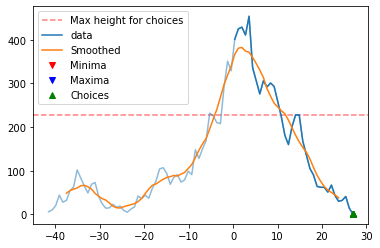

22400
47.37137137137062 0 17861 89 0.5322625996783216


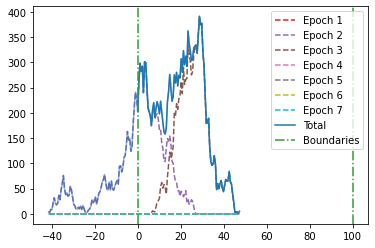

[21] {'prominences': array([78.55555556]), 'left_bases': array([5]), 'right_bases': array([53]), 'widths': array([19.32648515]), 'width_heights': array([-231.38888889]), 'left_ips': array([9.025]), 'right_ips': array([28.35148515])}
[53] {'prominences': array([155.55555556]), 'left_bases': array([22]), 'right_bases': array([85]), 'widths': array([23.42145594]), 'width_heights': array([269.88888889]), 'left_ips': array([35.]), 'right_ips': array([58.42145594])}
[167] [15.]
[167] [15.]
16 (array([167]), array([16]))


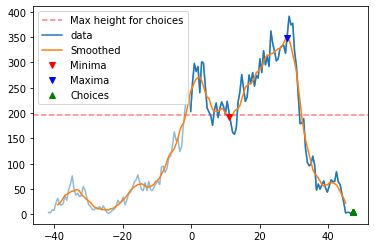

33600
67.91391391391342 0 29061 145 0.6791391391391342


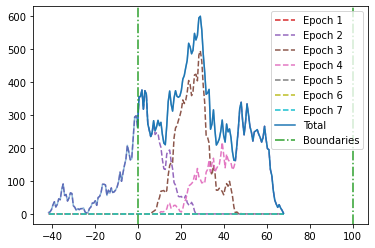

[16 64] {'prominences': array([80.        , 74.11111111]), 'left_bases': array([ 2, 40]), 'right_bases': array([40, 73]), 'widths': array([13.23081953, 15.91812865]), 'width_heights': array([-293.33333333, -253.83333333]), 'left_ips': array([ 7.7016129 , 54.28947368]), 'right_ips': array([20.93243243, 70.20760234])}
[40 73] {'prominences': array([286.77777778,  74.11111111]), 'left_bases': array([16, 64]), 'right_bases': array([96, 96]), 'widths': array([17.40096831,  9.62082903]), 'width_heights': array([396.72222222, 253.83333333]), 'left_ips': array([30.09375   , 70.20760234]), 'right_ips': array([47.49471831, 79.82843137])}
[77, 125, 161] [0.7371134  2.27835052 9.98453608]
[161, 125, 77] [9.98453608 2.27835052 0.7371134 ]
16 (array([ 77, 125, 161]), array([ 1,  4, 11]))


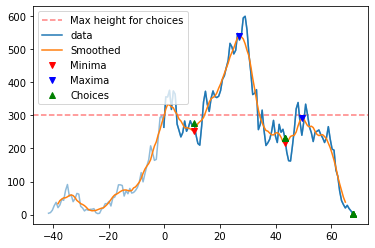

44800
95.72572572572527 0 40233 201 0.9572572572572526


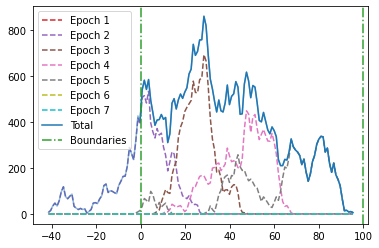

[10 39 78] {'prominences': array([92.33333333, 52.        , 66.88888889]), 'left_bases': array([ 3, 28, 28]), 'right_bases': array([28, 49, 85]), 'widths': array([7.38467554, 8.12354892, 7.22745353]), 'width_heights': array([-442.16666667, -509.        , -250.55555556]), 'left_ips': array([ 8.01642336, 36.32089552, 74.53543307]), 'right_ips': array([15.4010989 , 44.44444444, 81.7628866 ])}
[ 3 28 49 85] {'prominences': array([ 55.77777778, 342.33333333,  52.        ,  66.88888889]), 'left_bases': array([ 0, 10, 39, 78]), 'right_bases': array([10, 96, 96, 96]), 'widths': array([ 5.68378766, 13.31333051,  9.21409214,  6.75139912]), 'width_heights': array([460.44444444, 567.16666667, 509.        , 250.55555556]), 'left_ips': array([ 1.09268293, 21.33690987, 44.44444444, 81.7628866 ]), 'right_ips': array([ 6.77647059, 34.65024038, 53.65853659, 88.51428571])}
[121, 143, 43] [4.60747664 7.91588785 0.47663551]
[143, 121, 43] [7.91588785 4.60747664 0.47663551]
16 (array([ 43, 121, 143]), array

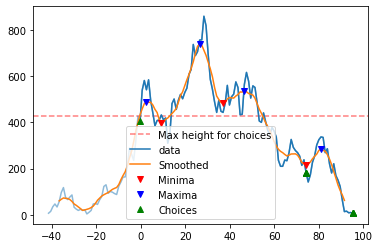

56000
100 0 49116 245 1.0


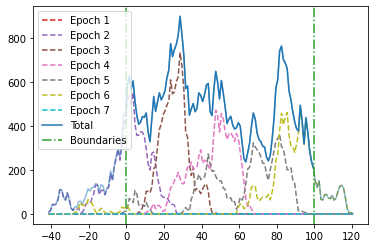

[10 38 62 74] {'prominences': array([100.88888889,  57.77777778,  28.        , 341.44444444]), 'left_bases': array([ 3, 27, 27, 27]), 'right_bases': array([27, 47, 70, 84]), 'widths': array([ 7.864129  ,  7.597543  ,  6.88786064, 25.32793424]), 'width_heights': array([-468.        , -531.88888889, -348.66666667, -477.05555556]), 'left_ips': array([ 7.49484536, 35.12972973, 60.74850299, 53.80607477]), 'right_ips': array([15.35897436, 42.72727273, 67.63636364, 79.13400901])}
[ 3 27 47 84] {'prominences': array([ 52.77777778, 352.        ,  57.77777778, 341.44444444]), 'left_bases': array([ 0, 10, 38, 74]), 'right_bases': array([ 10, 100,  74, 100]), 'widths': array([ 5.17634887, 12.80504762,  8.65175953, 10.92849099]), 'width_heights': array([492.05555556, 593.55555556, 531.88888889, 477.05555556]), 'left_ips': array([ 1.10209424, 20.564     , 42.72727273, 79.13400901]), 'right_ips': array([ 6.27844311, 33.36904762, 51.37903226, 90.0625    ])}
[51, 79, 103, 115, 141, 41] [1.02586976 0.66

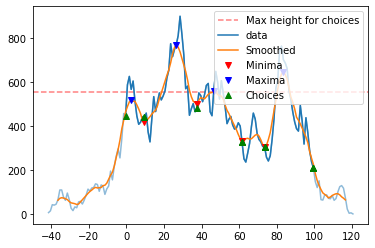

67200
100 0 57646 288 1.0


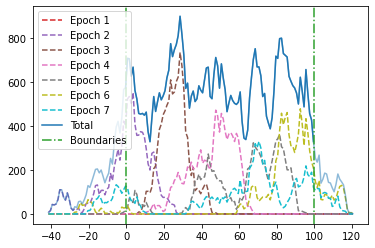

[10 37 61 75] {'prominences': array([161.33333333,  84.66666667, 261.55555556, 114.33333333]), 'left_bases': array([ 3, 27, 27, 70]), 'right_bases': array([27, 47, 84, 84]), 'widths': array([10.79033558,  8.43651904, 15.3788445 ,  5.77566807]), 'width_heights': array([-519.33333333, -588.11111111, -583.55555556, -571.83333333]), 'left_ips': array([ 6.97942387, 34.14529915, 52.45918367, 72.71044304]), 'right_ips': array([17.76975945, 42.58181818, 67.83802817, 78.48611111])}
[27 47 70 84] {'prominences': array([330.88888889,  84.66666667, 114.33333333, 261.55555556]), 'left_bases': array([10, 37, 61, 61]), 'right_bases': array([100,  61,  75, 100]), 'widths': array([12.76344681,  9.66818182,  5.24389374, 11.49171387]), 'width_heights': array([604.11111111, 588.11111111, 571.83333333, 583.55555556]), 'left_ips': array([20.944     , 42.58181818, 67.4665493 , 78.9047619 ]), 'right_ips': array([33.70744681, 52.25      , 72.71044304, 90.39647577])}
[51, 78, 102, 116, 141] [2.32097187 1.448849

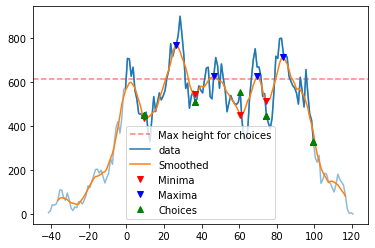

78400
100 0 66418 332 1.0


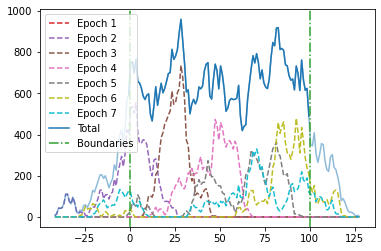

[12 36 62] {'prominences': array([116.33333333, 101.        , 288.77777778]), 'left_bases': array([ 4, 27, 27]), 'right_bases': array([27, 47, 83]), 'widths': array([10.07983313,  5.74112132, 20.13945342]), 'width_heights': array([-616.72222222, -630.05555556, -669.27777778]), 'left_ips': array([ 7.96733668, 33.71410256, 48.3778626 ]), 'right_ips': array([18.04716981, 39.45522388, 68.51731602])}
[ 4 27 47 83] {'prominences': array([ 80.11111111, 255.11111111, 101.        , 304.77777778]), 'left_bases': array([ 0, 12, 36, 62]), 'right_bases': array([ 12,  62,  62, 100]), 'widths': array([ 5.70320575, 10.97933614, 12.85914738, 24.3329675 ]), 'width_heights': array([634.83333333, 686.11111111, 630.05555556, 677.27777778]), 'left_ips': array([ 1.44503546, 21.3655914 , 39.45522388, 68.82900433]), 'right_ips': array([ 7.14824121, 32.34492754, 52.31437126, 93.16197183])}
[53, 77, 103, 141, 41] [2.58783364 1.61824953 2.7380509  2.7380509  1.31781502]
[103, 141, 53, 77, 41] [2.7380509  2.738050

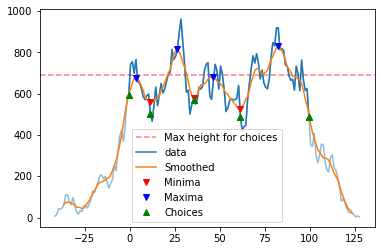

In [11]:
epochs = 7
N=16
maxval=100
minval=0
fval = []
reps = []
frms = []
epcs = []
for i in range(1,epochs+1):
    r,f,fr = simulate_data(i)
    if(i!=1):
        fval = [fval]
        reps = [reps]
        frms = [frms]
        epcs = [epcs]
    reps.append(r)
    fval.append(f)
    frms.append(fr)
    epcs.append(np.full(fval[-1].shape,i+1))

    reps = np.concatenate(reps)
    fval = np.concatenate(fval)
    epcs = np.concatenate(epcs)
    frms = np.concatenate(frms)
    
    hist, bin_edges, bin_centers, mask = make_hist(fval)
    chosen_bins = choose_bins(hist,mask,bin_centers)
    